In [83]:
# generative model
from src.SlovotvirModelM import run_model_parallel

# bayesflow components
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import (InvertibleNetwork, 
                                DeepSet)
from bayesflow.trainers import (Trainer, 
                                SimulationDataset)
import tensorflow as tf

# other
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import seaborn as sns
import arviz as az
from tabulate import tabulate
from sklearn.decomposition import PCA

In [84]:
RNG = np.random.default_rng(2023)

### 0. Functions and other supplements

In [102]:
def generate_latex_table(ps, post_samples):
    table_data = []
    for i, p in enumerate(ps):
        row = [p, np.mean(post_samples[:, i]).round(3), 
               az.hdi(post_samples[:, i], hdi_prob=0.95).round(3)]
        table_data.append(row)

    table_headers = ['Parameter', 'Mean', 'HDI']
    latex_table = tabulate(table_data, headers=table_headers, tablefmt='latex')
    return latex_table

In [85]:
# NB: PRIOR MEANS AND STD SHOULD BE THE SAME ACROSS THE BOARD

def configure_input(forward_dict, prior_means, prior_stds):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    # compute prior means and stds
    # prior_means = np.mean(params, axis=0)
    # prior_stds = np.std(params, axis=0)
    # z-standardize
    params = (params - prior_means) / prior_stds

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [86]:
# def binning(likes, bins=100):
#     likes = likes[:len(likes) - len(likes) % bins]
#     likes = likes.reshape(-1, bins).sum(axis=1)
#     return likes

def binning(likes):
    # Determine the number of bins based on the length of the likes array
    num_bins = int(np.ceil(np.log2(len(likes))))
    
    # Define bin edges at powers of 2 based on the indexes of likes
    bin_edges = 2 ** np.arange(num_bins + 1)
    
    # Assign values to bins
    bin_indices = np.digitize(np.arange(len(likes)), bin_edges)
    
    # Calculate the sum of values in each bin
    bin_sums = np.bincount(bin_indices, weights=likes, minlength=num_bins + 1)
    
    return bin_sums

In [125]:
def plot_posterior(post_samples_, param_names, true_values):
    num_params = len(param_names)
    fig, axs = plt.subplots(1, num_params, figsize=(10, 3.5))

    for i, param_name in enumerate(param_names):
        # Plot posterior density
        sns.kdeplot(post_samples_[:, i], ax=axs[i], color='blue')

        # Get KDE curve for each subplot
        x_values, y_values = sns.kdeplot(post_samples_[:, i], ax=axs[i], color='blue').lines[0].get_data()

        # Fill between specified points for KDE plot
        post_hdi = az.hdi(post_samples_[:, i], hdi_prob=0.95)
        axs[i].fill_between(x_values, y_values, where=(x_values >= post_hdi[0]) & (x_values <= post_hdi[1]), color='blue', alpha=0.3)

        # Plot prior density (assuming uniform for first two parameters and lognormal for the third)
        if i < 2:
            sns.kdeplot(np.random.uniform(0, 10, 10000), ax=axs[i], color='black', linestyle='--')
        else:
            sns.kdeplot(np.random.lognormal(0, sigma=0.5, size=10000), ax=axs[i], color='black', linestyle='--')

        # Plot true values
        axs[i].axvline(true_values[i], color='red', linestyle='--')

        if i == 0:
            axs[i].set_ylabel('Density')
        else:
            axs[i].set_ylabel('')

        # Set titles
        axs[i].set_title(param_name)


    # Custom legend handles
    posterior_line = lines.Line2D([], [], color='blue', linestyle='-')
    prior_line = lines.Line2D([], [], color='black', linestyle='--')

    # Add legend below the subplots
    plt.legend(handles=[posterior_line, prior_line],
               labels=['Posterior', 'Prior'],
               bbox_to_anchor=(-0.7, -0.2),
               loc='lower center', ncol=num_params,
               frameon=False)

    # Save to pdf
    # plt.savefig('figures/posterior.pdf', bbox_inches='tight', pad_inches=0)

    # Show the plot
    plt.show()

In [88]:
def train_and_amortize(train_data, batch_size, test_data, epochs, num_params, summary_dim, learning_rate, prior_means, prior_stds):
    # Define summary and inference networks
    summary_net = DeepSet(summary_dim=summary_dim)
    inference_net = InvertibleNetwork(num_params=num_params, num_coupling_layers=4)
    amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")
    
    # Define trainer
    trainer = Trainer(amortizer=amortizer, configurator=lambda x: configure_input(x, prior_means, prior_stds), memory=True)
    
    # Define learning rate schedule
    schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, 
                                                         epochs * SimulationDataset(train_data, 
                                                                                    batch_size).num_batches, 
                                                        name = "lr_decay")
    optimizer = tf.keras.optimizers.legacy.Adam(schedule, global_clipnorm = 1)
        
    # Run training
    history = trainer.train_offline(simulations_dict=train_data, epochs=epochs, 
                                    batch_size=batch_size, optimizer=optimizer, 
                                    validation_sims=test_data,
                                    early_stopping=True, patience=20)
    
    # Save the trainer
    trainer._save_trainer("model")
    
    return history, trainer, amortizer

In [24]:
fake_dist = run_model_parallel([10], [1], [1.3], 1)
fake_dist_bins = binning(fake_dist[0])

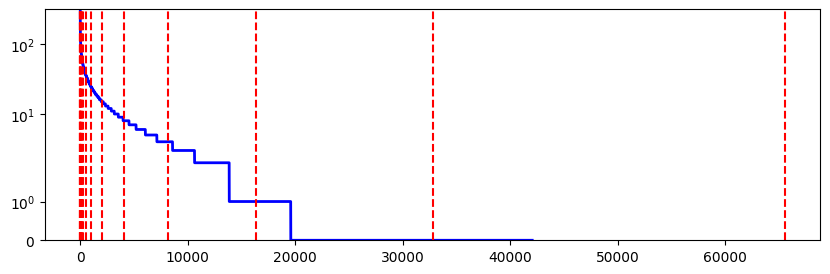

In [25]:
# plot fake dist
plt.figure(figsize=(10, 3))
plt.plot(fake_dist[0], color='blue', linewidth=2)
plt.grid(False)
# add vertical lines at powers of 2
for i in range(1, 17):
    plt.axvline(2 ** i, color="red", linestyle="--", alpha=1)
    # add text from fake_dist_bins turn 90 degrees
    # plt.text(2 ** i - 1, 10^4, str(fake_dist_bins[i-1]), rotation=90)
# plt.xscale("log")
plt.yscale("symlog", base=10)
plt.ylim(0, None)
# plt.xscale("log")
plt.show()

## Inference of all 3 parameters

In [ ]:
train_size = 1000
test_size = 10
valid_size = 10

### 1. Generating training and testing data

In [ ]:
training_params = (np.random.uniform(0, 10, train_size), np.random.uniform(0, 10, train_size), np.random.lognormal(0, 0.5, train_size))
testing_params = (np.random.uniform(0, 10, test_size), np.random.uniform(0, 10, test_size), np.random.lognormal(0, 0.5, test_size))
validation_params = (np.random.uniform(0, 10, valid_size), np.random.uniform(0, 10, valid_size), np.random.lognormal(0, 0.5, valid_size))

In [ ]:
prior_means = np.mean(training_params, axis=1)
prior_stds = np.std(training_params, axis=1)

In [ ]:
training_data = run_model_parallel(training_params[0], training_params[1], training_params[2], train_size)

In [ ]:
testing_data = run_model_parallel(testing_params[0], testing_params[1], testing_params[2], test_size)

In [ ]:
validation_data = run_model_parallel(validation_params[0], validation_params[1], validation_params[2], valid_size)

In [ ]:
training_params = np.vstack(training_params)
testing_params = np.vstack(testing_params)
validation_params = np.vstack(validation_params)

In [ ]:
train_data = {}
train_data["prior_non_batchable_context"] = None
train_data["prior_batchable_context"] = None
train_data["prior_draws"] = training_params.reshape(num_params, train_size).T
train_data["sim_non_batchable_context"] = None
train_data["sim_batchable_context"] = None
train_data["sim_data"] = np.array(training_data, dtype = float)


test_data = {}
test_data["prior_non_batchable_context"] = None
test_data["prior_batchable_context"] = None
test_data["prior_draws"] = testing_params.reshape(num_params, test_size).T
test_data["sim_non_batchable_context"] = None
test_data["sim_batchable_context"] = None
test_data["sim_data"] = np.array(testing_data, dtype = float)

valid_data = {}
valid_data["prior_non_batchable_context"] = None
valid_data["prior_batchable_context"] = None
valid_data["prior_draws"] = validation_params.reshape(num_params, valid_size).T
valid_data["sim_non_batchable_context"] = None
valid_data["sim_batchable_context"] = None
valid_data["sim_data"] = np.array(validation_data, dtype = float)

In [28]:
# pickle.dump(train_data, open("data/train_data_1405.pkl", "wb"))
# pickle.dump(test_data, open("data/test_data_1405.pkl", "wb"))
# pickle.dump(valid_data, open("data/valid_data_1405.pkl", "wb"))
# load data
train_data = pickle.load(open("data/train_data_1405.pkl", "rb"))
test_data = pickle.load(open("data/test_data_1405.pkl", "rb"))
valid_data = pickle.load(open("data/valid_data_1405.pkl", "rb"))

In [13]:
# train_data_ = pickle.load(open("data/train_data_1205.pkl", "rb"))
# test_data_ = pickle.load(open("data/test_data_1205.pkl", "rb"))
# valid_data_ = pickle.load(open("data/valid_data_1205.pkl", "rb"))

In [14]:
# # train_data["sim_data"].shape
# train_data_["sim_data"] = np.array(list(map(binning, train_data_["sim_data"])))
# test_data_["sim_data"] = np.array(list(map(binning, test_data_["sim_data"])))
# valid_data_["sim_data"] = np.array(list(map(binning, valid_data_["sim_data"])))

In [15]:
# # combine sim_data and prior_draws
# train_data["sim_data"] = np.concatenate((train_data["sim_data"], train_data_["sim_data"]))
# train_data["prior_draws"] = np.concatenate((train_data["prior_draws"], train_data_["prior_draws"]))
# test_data["sim_data"] = np.concatenate((test_data["sim_data"], test_data_["sim_data"]))
# test_data["prior_draws"] = np.concatenate((test_data["prior_draws"], test_data_["prior_draws"]))
# valid_data["sim_data"] = np.concatenate((valid_data["sim_data"], valid_data_["sim_data"]))
# valid_data["prior_draws"] = np.concatenate((valid_data["prior_draws"], valid_data_["prior_draws"]))

In [29]:
# # apply binning to each entry in sim_data using map
# train_data["sim_data"] = np.array(list(map(binning, train_data["sim_data"])))
# test_data["sim_data"] = np.array(list(map(binning, test_data["sim_data"])))
# valid_data["sim_data"] = np.array(list(map(binning, valid_data["sim_data"])))

In [79]:
prior_means = np.mean(train_data["prior_draws"], axis=0)
prior_stds = np.std(train_data["prior_draws"], axis=0)

In [80]:
train_data['sim_data'].shape

(80000, 17)

### 2. Training the model

In [81]:
num_params = 3
epochs = 10
batch_size = 32
learning_rate = 0.001

In [89]:
history, trainer, amortizer = train_and_amortize(train_data, batch_size, test_data, epochs, 
                                                 num_params, 4, learning_rate, prior_means, prior_stds)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.860


Training epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.038


Training epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.873


Training epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.688


Training epoch 5:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.683


Training epoch 6:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.368


Training epoch 7:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.182


Training epoch 8:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.051


Training epoch 9:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: -0.057


Training epoch 10:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -0.077


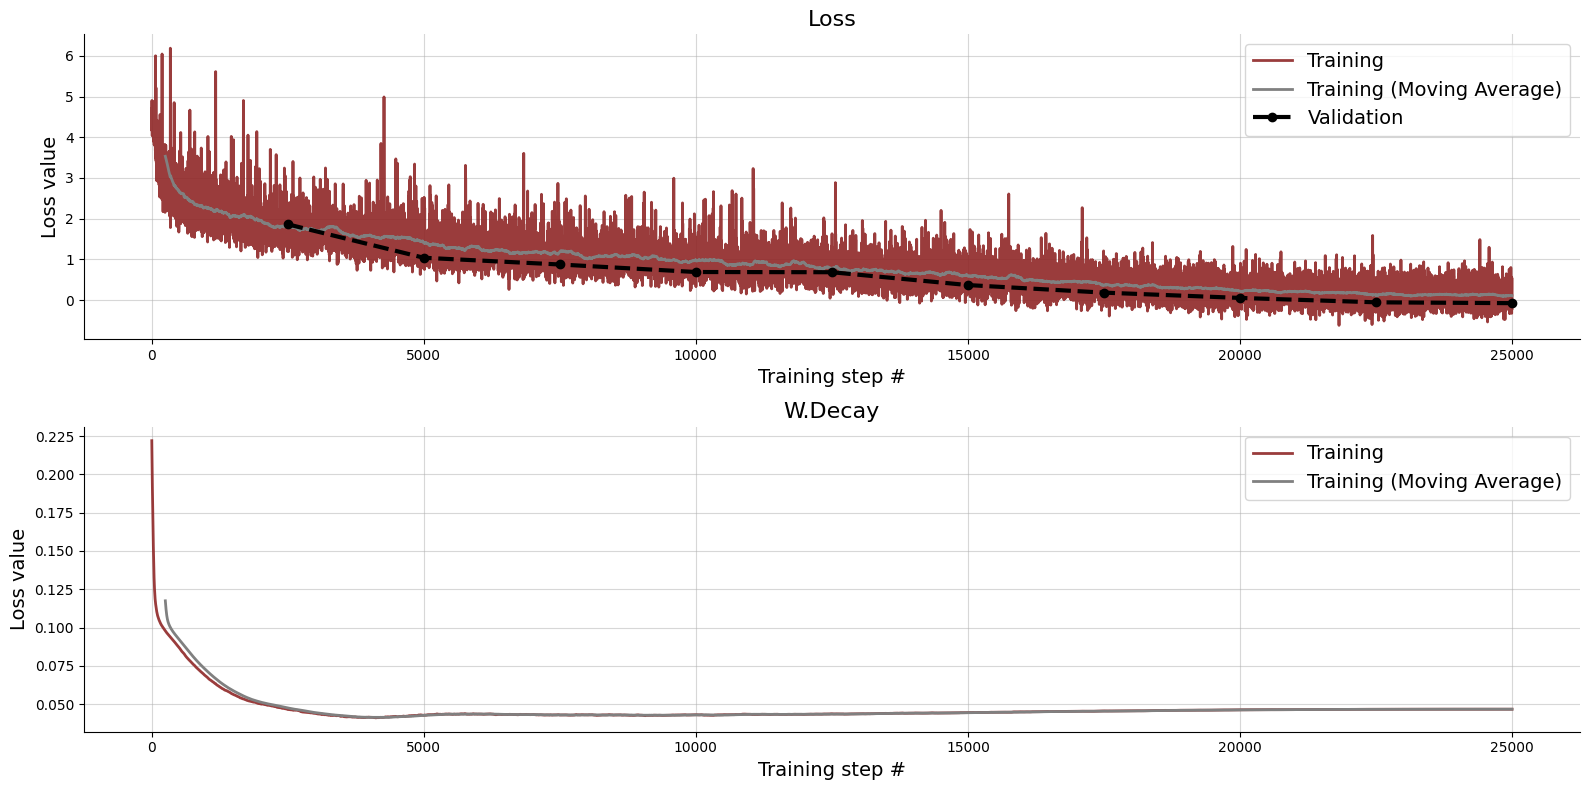

In [90]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

### 3. Model analysis

In [91]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data) 
prior_samples = validation_sims["parameters"] * prior_stds + prior_means
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds + prior_means

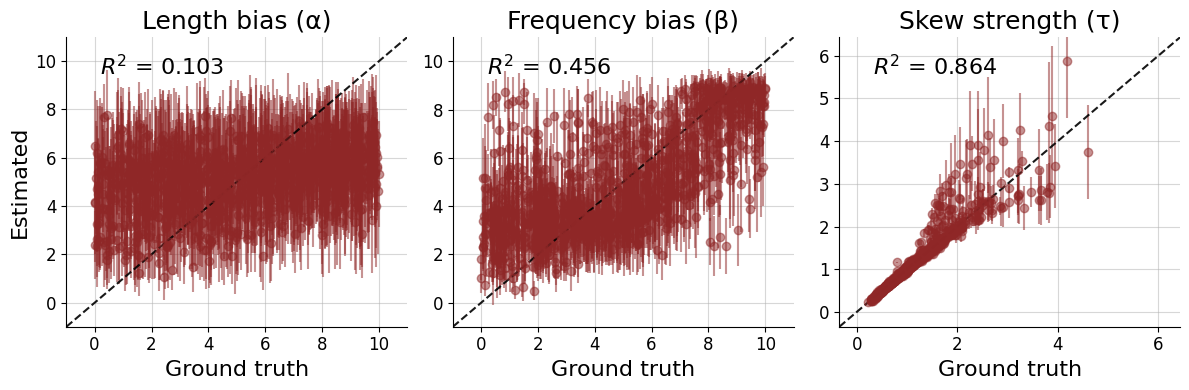

In [92]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

In [93]:
post_samples.shape

(8000, 100, 3)

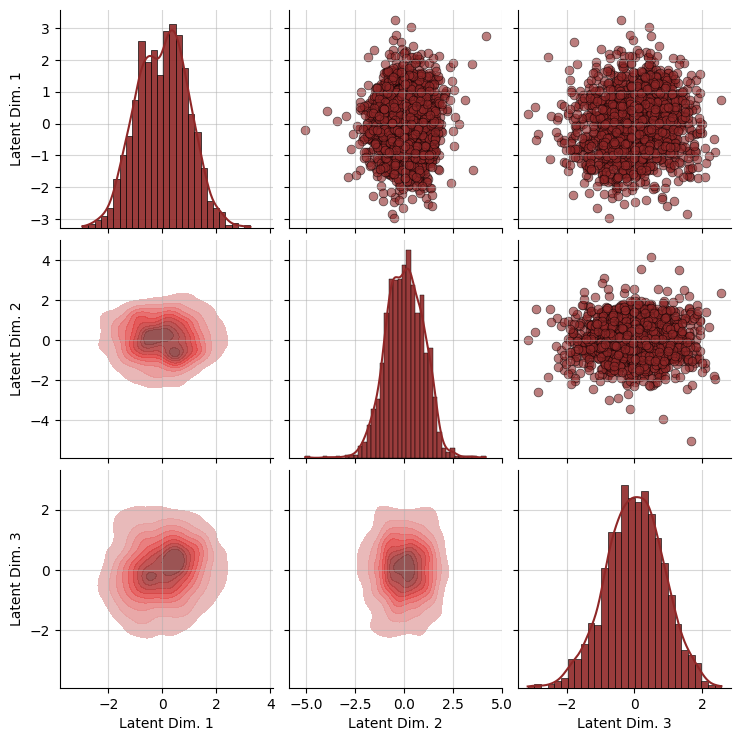

In [94]:
f = trainer.diagnose_latent2d()

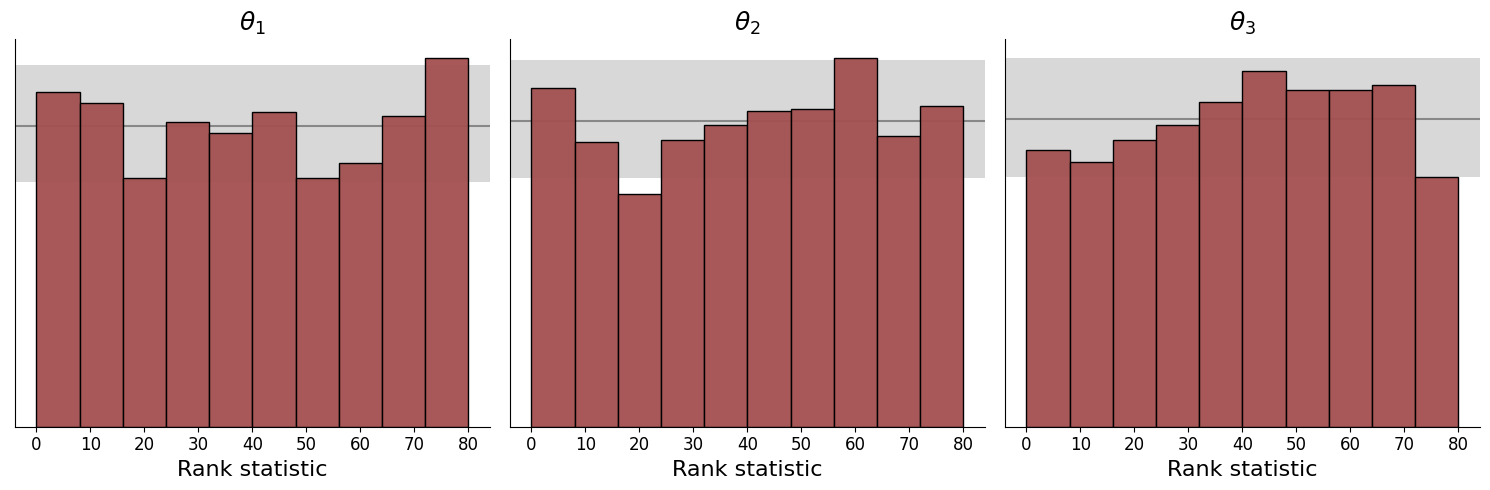

In [95]:
f = trainer.diagnose_sbc_histograms()

### 4. Posterior analysis

In [137]:
a = 10
b = 1
tau = 2

In [138]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
# apply binning to each entry in sim_data using map
fake_dist = np.array(list(map(binning, fake_dist)))

In [139]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [140]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

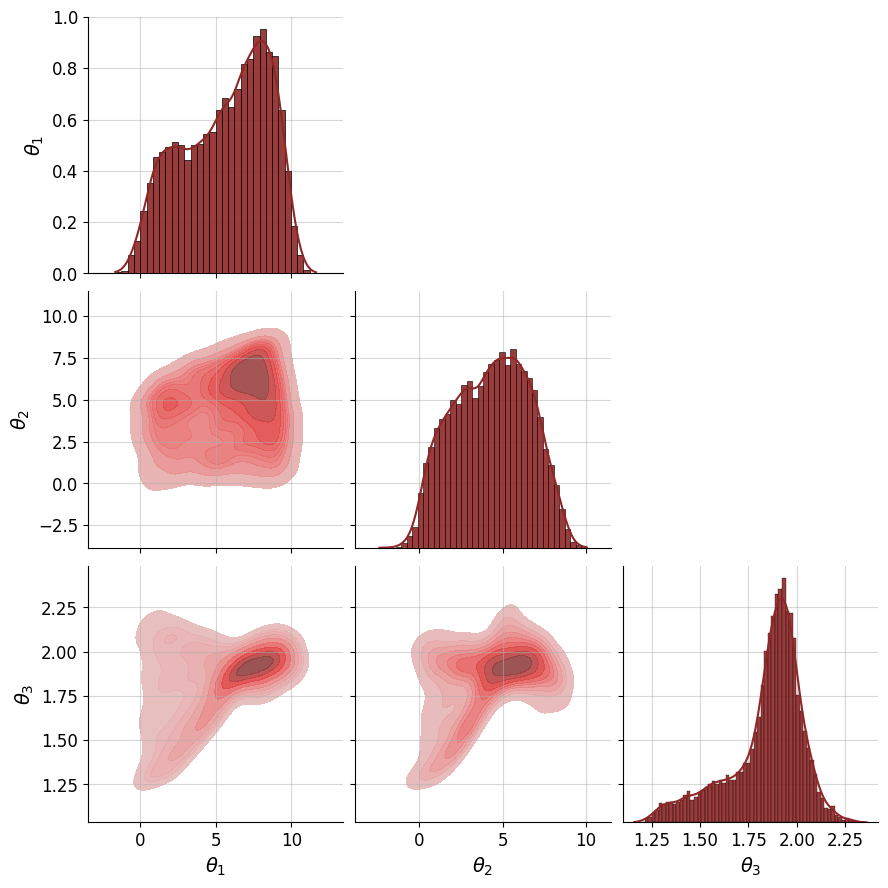

In [141]:
f = diag.plot_posterior_2d(post_samples_)

In [142]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI           \\
\hline
 Length bias (α)    &  5.64  & [0.491 9.975] \\
 Frequency bias (β) &  4.292 & [0.177 8.166] \\
 Skew strength (τ)  &  1.842 & [1.371 2.142] \\
\hline
\end{tabular}


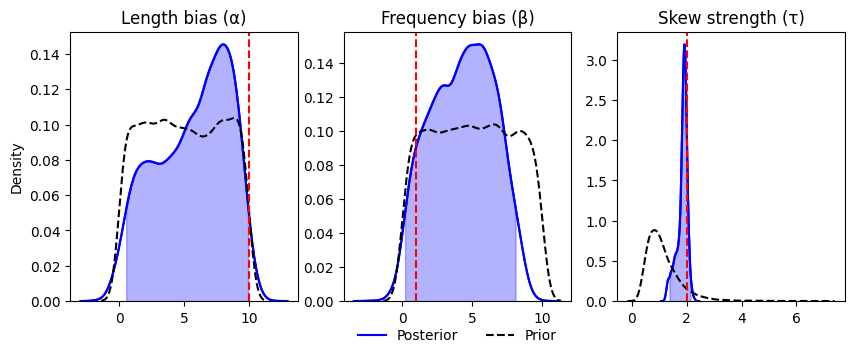

In [143]:
plot_posterior(post_samples_, ['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], [a, b, tau])

In [144]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(train_data['sim_data'])

true_hist = obs_data.reshape(1, -1)
pca_true = pca.transform(true_hist)

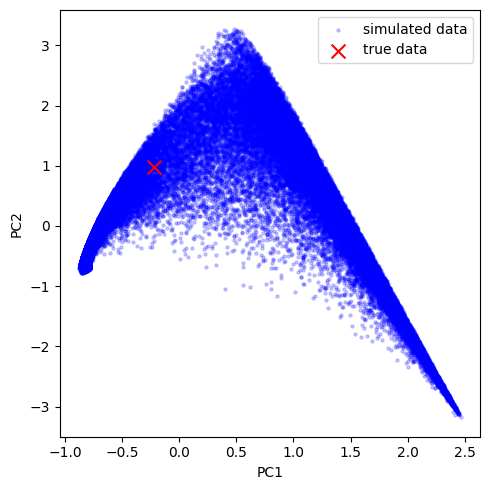

In [145]:
# Plot PCA
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.2, label='simulated data')
plt.scatter(pca_true[:, 0], pca_true[:, 1],
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/pca.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Inference of alpha and beta knowing tau

### 1. Data generation

In [146]:
train_size = 1000
test_size = 10
valid_size = 10

num_params = 2

In [147]:
np.mean(post_samples_[:, 2])

1.842400345652659

In [148]:
training_params_2 = (np.random.uniform(0, 10, train_size), 
                   np.random.uniform(0, 10, train_size), 
                  [np.mean(post_samples_[:, 2])] * train_size)
testing_params_2 = (np.random.uniform(0, 10, test_size), 
                  np.random.uniform(0, 10, test_size), 
                 [np.mean(post_samples_[:, 2])] * test_size)
validation_params_2 = (np.random.uniform(0, 10, valid_size), 
                     np.random.uniform(0, 10, valid_size),
                    [np.mean(post_samples_[:, 2])] * valid_size)

In [149]:
training_data_2 = run_model_parallel(training_params_2[0], training_params_2[1], training_params_2[2], train_size)

In [150]:
testing_data_2 = run_model_parallel(testing_params_2[0], testing_params_2[1], testing_params_2[2], test_size)

In [151]:
validation_data_2 = run_model_parallel(validation_params_2[0], validation_params_2[1], validation_params_2[2], valid_size)

In [152]:
training_params_2 = np.vstack(training_params_2)
testing_params_2 = np.vstack(testing_params_2)
validation_params_2 = np.vstack(validation_params_2)

In [153]:
# remove last array from params
training_params_2 = training_params_2[:-1]
testing_params_2 = testing_params_2[:-1]
validation_params_2 = validation_params_2[:-1]

In [154]:
train_data_2 = {}
train_data_2["prior_non_batchable_context"] = None
train_data_2["prior_batchable_context"] = None
train_data_2["prior_draws"] = training_params_2.reshape(num_params, train_size).T
train_data_2["sim_non_batchable_context"] = None
train_data_2["sim_batchable_context"] = None
train_data_2["sim_data"] = np.array(training_data_2, dtype = float)


test_data_2 = {}
test_data_2["prior_non_batchable_context"] = None
test_data_2["prior_batchable_context"] = None
test_data_2["prior_draws"] = testing_params_2.reshape(num_params, test_size).T
test_data_2["sim_non_batchable_context"] = None
test_data_2["sim_batchable_context"] = None
test_data_2["sim_data"] = np.array(testing_data_2, dtype = float)

valid_data_2 = {}
valid_data_2["prior_non_batchable_context"] = None
valid_data_2["prior_batchable_context"] = None
valid_data_2["prior_draws"] = validation_params_2.reshape(num_params, valid_size).T
valid_data_2["sim_non_batchable_context"] = None
valid_data_2["sim_batchable_context"] = None
valid_data_2["sim_data"] = np.array(validation_data_2, dtype = float)

In [155]:
# train_data["sim_data"].shape
train_data_2["sim_data"] = np.array(list(map(binning, train_data_2["sim_data"])))
test_data_2["sim_data"] = np.array(list(map(binning, test_data_2["sim_data"])))
valid_data_2["sim_data"] = np.array(list(map(binning, valid_data_2["sim_data"])))

In [156]:
prior_means_2 = np.mean(train_data_2["prior_draws"], axis=0)
prior_stds_2 = np.std(train_data_2["prior_draws"], axis=0)

### 2. Model training

In [157]:
num_params = 2
epochs = 10
batch_size = 32
learning_rate = 0.001

history_2, trainer_2, amortizer_2 = train_and_amortize(train_data_2, batch_size, test_data_2, 
                                                       epochs, num_params, 4, learning_rate, prior_means_2, prior_stds_2)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.287


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 3.269


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 3.269


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 3.268


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 3.272


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 3.273


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 3.262
INFO:root:Early stopping triggered.


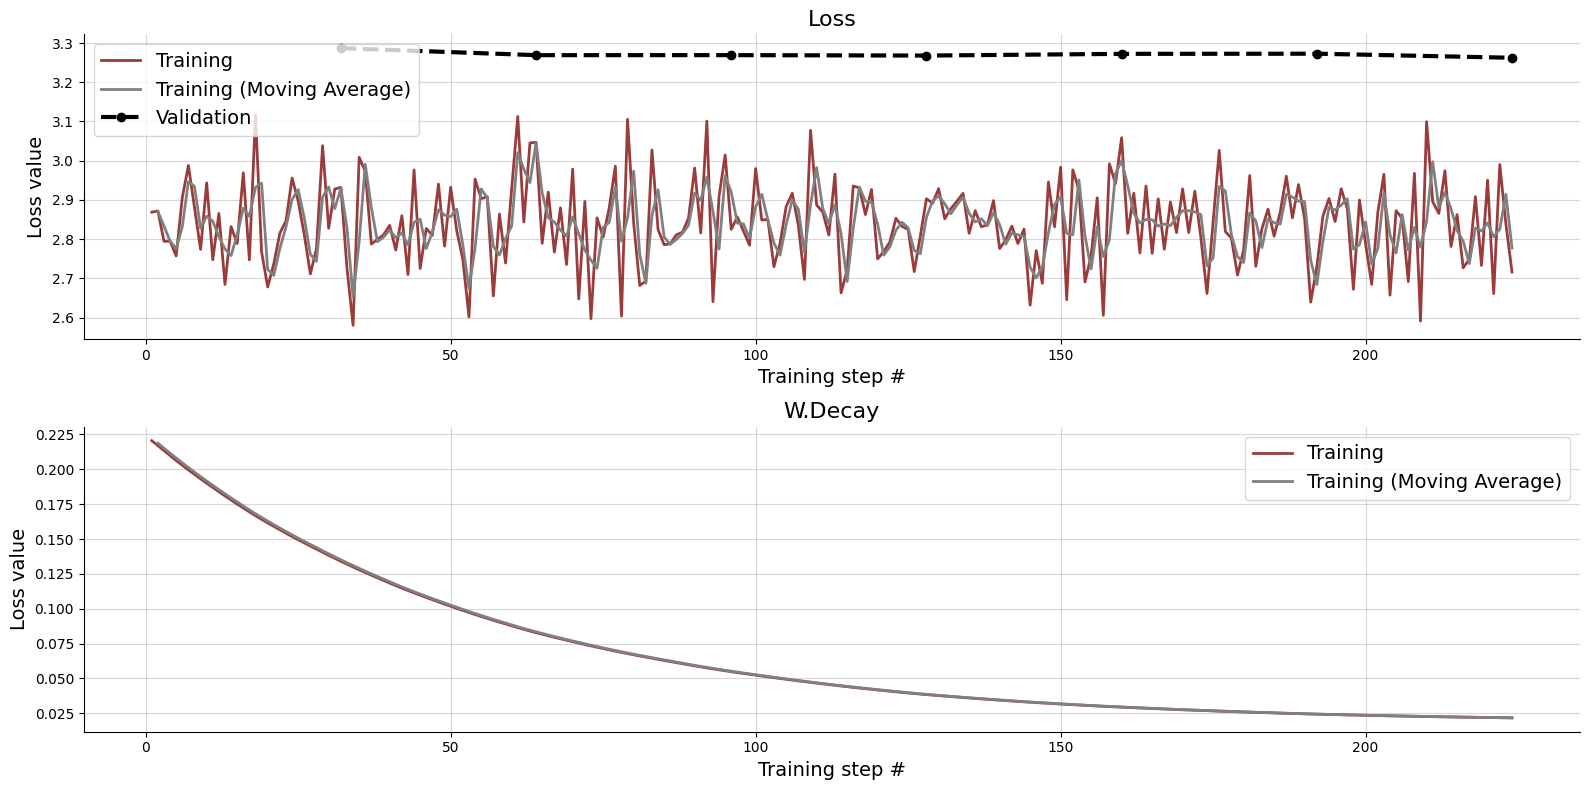

In [161]:
f = diag.plot_losses(history_2["train_losses"], history_2["val_losses"], moving_average=True)

In [164]:
# Generate some validation data
validation_sims = trainer_2.configurator(valid_data_2) 
prior_samples = validation_sims["parameters"] * prior_stds_2 + prior_means_2
# Generate posterior draws for all simulations
post_samples = amortizer_2.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds_2 + prior_means_2

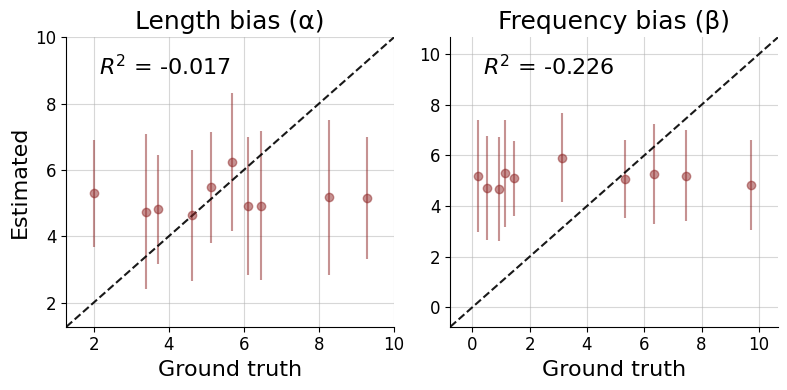

In [165]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

### 4. Posterior analysis

In [166]:
a = 1
b = 10
tau = np.mean(post_samples_[:, 2])

In [167]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
fake_dist = np.array(list(map(binning, fake_dist)))

In [168]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [170]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer_2.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means_2 + post_samples_ * prior_stds_2

In [173]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  5.11  & [-0.433 10.942] \\
 Frequency bias (β) &  4.943 & [-0.922 10.484] \\
\hline
\end{tabular}


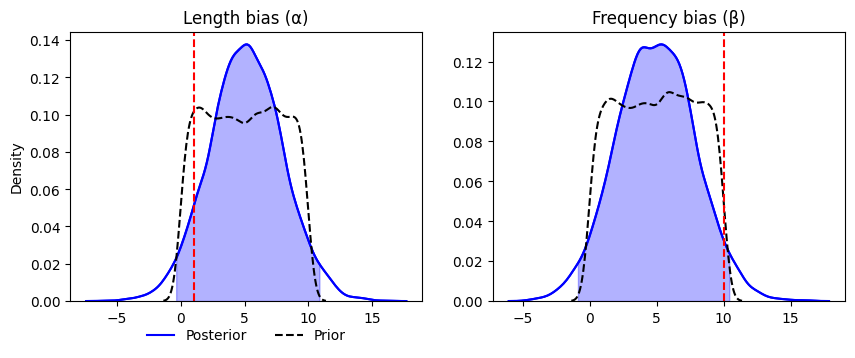

In [172]:
plot_posterior(post_samples_, ['Length bias (α)', 'Frequency bias (β)'], [a, b])